In [104]:
# This code will perform perform SVD on the A matrix and extract the relevant coherent structures

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

In [106]:
# Read Input
def read_variables_to_globals(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    for i in range(0, len(lines), 2):
        var_name = lines[i]
        raw_value = lines[i+1]

        try:
            value = int(raw_value)
        except ValueError:
            try:
                value = float(raw_value)
            except ValueError:
                value = raw_value

        globals()[var_name] = value  # Define variable in global scope

In [107]:
# Perform SVD on a normal computer
# Compute Correlation matrix 
#   -> Compute eigenvectors (temporal modes) and square root of eigenvalues of correlation matrix (singular values)
#       ->
def POD_regular(ProjectName, NumSS, NumModes):
    # NumSS == Number of Snapshots -> Determines how big the square matrix is 
    corr = np.zeros((NumSS, NumSS))  # Initialize correlation matrix

    # Perform every dot product combo on the column snapshots in order to build the correlation matrix
    for i in range(NumSS):
        for j in range(i, NumSS):  # j starts at i
            snap_id_a = i + 1
            snap_id_b = j + 1

            snap_filename_a = ProjectName + "_SnapShot_"  + str(snap_id_a) + ".txt"
            snap_filename_b = ProjectName + "_SnapShot_"  + str(snap_id_b) + ".txt"

            snap_a = np.loadtxt(snap_filename_a)
            snap_b = np.loadtxt(snap_filename_b)

            corr[i, j] = np.dot(snap_a, snap_b) 
            corr[j, i] = corr[i, j]       # fill symmetric entry
    
    print("Number of Modes we want to compute:")
    print(NumModes)

    print("Correlation Matrix By hand:")
    print(corr)

    eig_corr, tempModes = eigsh(corr, k=NumModes)
    
    tempModes = tempModes[:, ::-1]  # Flip columns

    Vt = np.transpose(tempModes)
    S = np.sqrt(eig_corr)

    S = S[::-1]

    print("From manual:")
    print(S)
    print(Vt)


    # # Validate Correlation Matrix through direct computation
    # snapshot_mat_full =  np.loadtxt("ToyData_Snapshot_Mat.txt")
    # corr_val = np.dot(np.transpose(snapshot_mat_full), snapshot_mat_full)

    # print("Correlation Matrix for Validation:")
    # print(corr_val)

    return S, Vt

In [108]:
# This Block is for validating the above block to make sure that what it is outputting makes sense
def POD_regular_validate(ProjectName):
    SnapShotMat_filename = ProjectName + "_SnapShot_Mat.txt"
    SnapShot_Mat = np.loadtxt(SnapShotMat_filename)
    U, S, Vt = np.linalg.svd(SnapShot_Mat, full_matrices=False)
    print("From validation:")
    #print("U =", U)
    print("S =", S)
    print("V^T =", Vt)
    return U, S, Vt

In [109]:
# Plot Log of normalized singular values
def plot_singular(S, titlename):
    # Create the plot

    x = np.arange(1, len(S) + 1)
    plt.plot(x, S)

    # Add labels and title
    plt.xlabel('Singular Values')
    plt.ylabel('Value')
    plt.title(titlename)

    # Show the plot
    plt.show()

In [110]:
def main(ProjectName, NumSS, NumModes):
    # SVD for computation of 
    S, Vt = POD_regular(ProjectName, NumSS, NumModes)
    # SVD on complete matrix for validation
    U_val, S_val, Vt_val = POD_regular_validate(ProjectName)

    return S, Vt, U_val, S_val, Vt_val

Number of Modes we want to compute:
5
Correlation Matrix By hand:
[[501. 493. 393. 319. 377.]
 [493. 560. 431. 338. 334.]
 [393. 431. 500. 305. 365.]
 [319. 338. 305. 323. 309.]
 [377. 334. 365. 309. 435.]]
From manual:
[44.18105164 13.08418101 10.67028131  8.38289546  3.42214017]
[[-0.48261011 -0.50118597 -0.4600497  -0.36336126 -0.41499755]
 [-0.26972765 -0.61282255  0.14762291  0.22648594  0.69181436]
 [ 0.37087019  0.01948682 -0.85177599  0.26596902  0.25654183]
 [-0.44749461  0.1298917  -0.03179329  0.82343846 -0.32220338]
 [ 0.59710832 -0.59666536  0.20007147  0.26054233 -0.42372302]]
From validation:
S = [44.18105164 13.08418101 10.67028131  8.38289546  3.42214017]
V^T = [[-0.48261011 -0.50118597 -0.4600497  -0.36336126 -0.41499755]
 [-0.26972765 -0.61282255  0.14762291  0.22648594  0.69181436]
 [ 0.37087019  0.01948682 -0.85177599  0.26596902  0.25654183]
 [-0.44749461  0.1298917  -0.03179329  0.82343846 -0.32220338]
 [-0.59710832  0.59666536 -0.20007147 -0.26054233  0.42372302

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


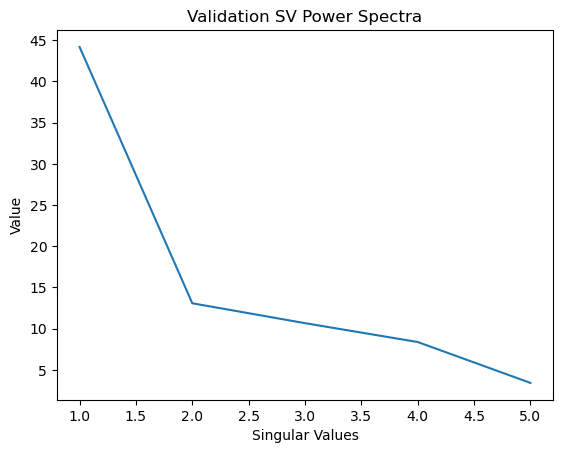

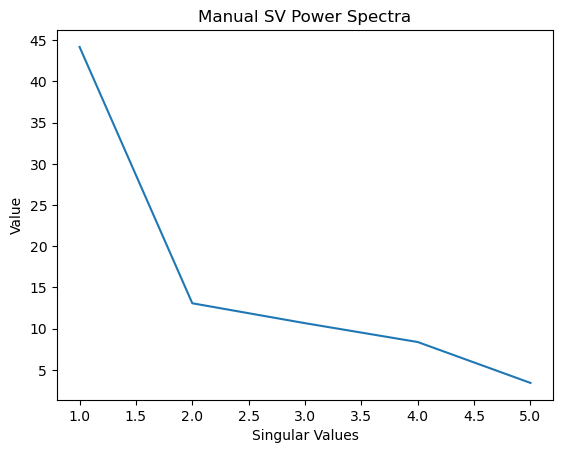

In [111]:
if __name__ == "__main__":
    # Read Variables
    inputs = read_variables_to_globals("input_POD.txt")
    
    S, Vt, U_val, S_val, Vt_val = main(ProjectName, 5, 5)

    plot_singular(S_val, 'Validation SV Power Spectra')

    plot_singular(S, 'Manual SV Power Spectra')